(planning_acting)=
# Planning and acting with predictive coding networks

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ComputationalPsychiatry/pyhgf/blob/master/docs/source/notebooks/0.4-Planning_and_acting.ipynb)

In [1]:
import sys

from IPython.utils import io

if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
from pyhgf.model import Network
from jax import random
from pyhgf import load_data
from pyhgf.utils import sample_node_distribution
np.random.seed(123)
plt.rcParams["figure.constrained_layout.use"] = True

This section concerns the application of predictive coding networks to planning and acting. While Bayesian filtering has been applied so far to the perceptual component of the agent, here we are interested in active inference and decision making, where an agent use its current beliefs to estimate future trajectories and select action based on there planned relevance.

## Adding an action layer

By adding a step in the belief propagation function, we can create agents that perform actions and interact with the environment (e.g., influencing the observation it might be presented). When provided, a new function, `action_fn,` can perform actions, decide, or influence the environment after the prediction step and before the observation step.

```{mermaid}
flowchart TB
  A[Predictions] -- Action_fn --> B[Observation]  --> C[Prediction-errors]
```

We illustrate how to implement this by using a two-bandit design, where the value of the contingencies increases or decreases depending on whether the bandit is exploited by the agent. An exploited bandit will decrease its contingency such as: $c = c - (\lambda c)$, whereas a bandit that was not exploited will increase its contingency such as: $c = c + \lambda * (1 - c)$. We, therefore, have to interact with the environment inside the inference loop. Luckily, we can do this by defining the corresponding action function.

In [ ]:
# we start by defining a simple network with two binary branches
network = (
    Network()
    .add_nodes(kind="binary-state", n_nodes=2)
    .add_nodes(value_children=0, tonic_volatility=-2.0)
    .add_nodes(value_children=1, tonic_volatility=-2.0)
)
network.plot_network()

Here, we want to access information from the environment during inference, so we have to wrap this into the `Network.attributes` instance. By convention, all items indexed with positive integers are nodes from the network, and we should not interact with them. Negative integers can be used to index additional information. For example, the time steps are stored in `attributes[-1]["time-steps"]`. Here, we will simply store the contingencies of the two bandits inside the same branch.

In [ ]:
network.attributes[-1]["contingencies"] = jnp.array([.5, .5])

We then define the action function. This function should receive and return the `attributes` dictionary, and the `inputs` tuple. By modifying values in this variable, we can change the observed values before they enter the network.

In [ ]:
def action_fn(attributes, inputs):

    # unpack the inputs
    values_tuple, observed_tuple, time_step, rng_key = inputs

    # get the current expectation for a reward for both bandits
    mu_0 = attributes[0]["expected_mean"]
    mu_1 = attributes[1]["expected_mean"]

    # sample a new reward from both bandits - the unobserved value will be masked later
    # here simply use the highest expected value to select the bandit
    values_tuple = (
        jnp.int32(random.bernoulli(rng_key, p=attributes[-1]["contingencies"][0])), 
        jnp.int32(random.bernoulli(rng_key, p=attributes[-1]["contingencies"][1])))
    observed_tuple = (jnp.int32(mu_0 - mu_1 > 0), jnp.int32(mu_0 - mu_1 <= 0))

    # decrease value of the contingencies for the exploited bandit and increse the value of the non exploited one
    exploited = attributes[-1]["contingencies"] - .1 * attributes[-1]["contingencies"]
    non_exploited = attributes[-1]["contingencies"] + .1 * (1.0 - attributes[-1]["contingencies"])
    attributes[-1]["contingencies"] = jnp.where(jnp.array(observed_tuple), exploited, non_exploited)

    # create a new input tuple
    inputs = values_tuple, observed_tuple, time_step, rng_key

    return attributes, inputs

We can now provide this function to our main `Network` class, so the model will be aware that this function should be executed inside the belief propagation step.

In [ ]:
network.action_fn = action_fn

We are now ready to run the model forward. Here, the input data only inform the number of time steps because we are fully overwriting the input values inside the action function, we could provide any kind of array of same shape and type as well.

In [ ]:
# because there is a stochastic component in the reward, we need to pass a pseudorandom number generators
rng_key = random.PRNGKey(0)
network.input_data(input_data=np.ones((100, 2)), rng_keys=random.PRNGKey(0));

In [ ]:
_, axs = plt.subplots(figsize=(12, 5), nrows=2, sharex=True)

for i in range(2):
    axs[i].plot(network.node_trajectories[-1]["contingencies"][:, i], label="Reward probability")
    axs[i].plot(network.node_trajectories[i]["expected_mean"], color="seagreen", label="Agent's expectations")
    axs[i].fill_between(
        x=jnp.arange(0, len(network.node_trajectories[-1]["time_step"])),
        y1=0, y2=1, where=network.node_trajectories[i]["observed"],
        alpha=.1, color="firebrick", label="Selected agent"
    )
    axs[i].scatter(
        x=jnp.arange(0, len(network.node_trajectories[-1]["time_step"]))[network.node_trajectories[i]["observed"].astype(bool)],
        y=network.node_trajectories[i]["mean"][network.node_trajectories[i]["observed"].astype(bool)],
        edgecolor="k", label="Observed rewards"
    )
    axs[i].set(ylabel=f"Bandit - {i}")
    axs[i].legend(loc="upper right")

sns.despine()

## Sampling belief trajectories

In this notebook, we first create two agents: one with a binary child node (where the inputs are observed) and one with a continuous child node.
Rather than merely observing data, we want our agents to think and simulate the future by sampling from their own distributions and then inserting the samples as observations.

### Sampling the child nodes

#### Define an Agent with a Continuous Node
We create an agent with two nodes, including a child continuous node as the input.

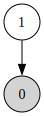

In [3]:
# Define an agent with a continuous node and display the network
agent_1 = (
    Network()  # Create a new network
    .add_nodes(precision=1e1)  # Add Node 1: Continuous node with a specified precision
    .add_nodes(value_children=[0])  # Add Node 2: Child node linked to Node 1
)
# Plot the network structure
agent_1.plot_network()

#### Sample from the Continuous Node
We sample 100 values from the continuous latent node x_0 \sim \mathcal{N}(0, 0.1).
This shows the empirical distribution of the node under its prior.
This is useful for verifying the prior shape and for further simulations.


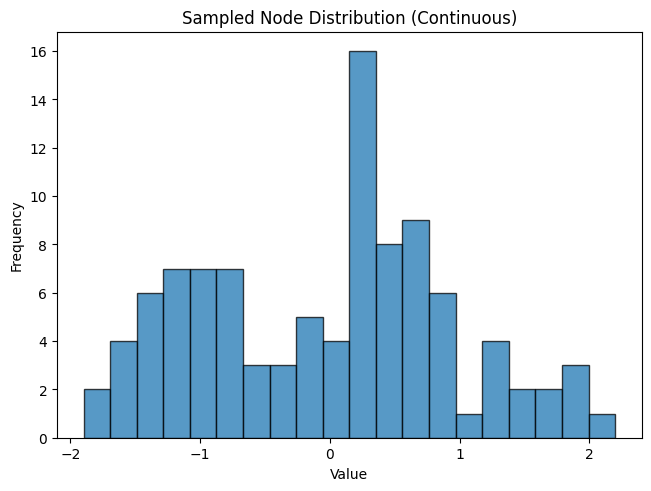

In [4]:
# Run the scan to generate multiple samples
num_samples = 100  # Number of samples to generate
rng_key = random.PRNGKey(0)  # Random number generator key
samples = sample_node_distribution(
    attributes= agent_1.attributes,        # Network attributes
    node_idx = 0,                         # Node index to sample from
    rng_key= rng_key,                   # Random number generator key
    edges = agent_1.edges, # Node type for the specified node
)
# Set the number of samples
num_samples = 100  # Number of times to sample
rng_key = random.PRNGKey(0)  # Base random number generator key

# Initialize a list to collect all samples
all_samples = []

# Loop to generate samples
for i in range(num_samples):
    subkey = random.fold_in(rng_key, i)  # Get a new subkey for each iteration
    sample = sample_node_distribution(
        attributes=agent_1.attributes,
        node_idx=0,
        rng_key=subkey,
        edges=agent_1.edges,
    )
    all_samples.append(sample)  # Append the sample to the list


# Plot the accumulated samples
plt.hist(all_samples, bins=20, alpha=0.75, edgecolor='k')
plt.title("Sampled Node Distribution (Continuous)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

#### 📌 3. Load Time Series Data and Run Inference
We load time-series observations and inject them as data into the model.
The network will use Bayesian message passing to update beliefs over time, which can be written as:


array([<Axes: title={'left': 'State Node 1'}, ylabel='$\\mu_{1}$'>,
       <Axes: title={'left': 'Continuous Input Node 0'}, xlabel='Time', ylabel='$\\mu_{0}$'>],
      dtype=object)

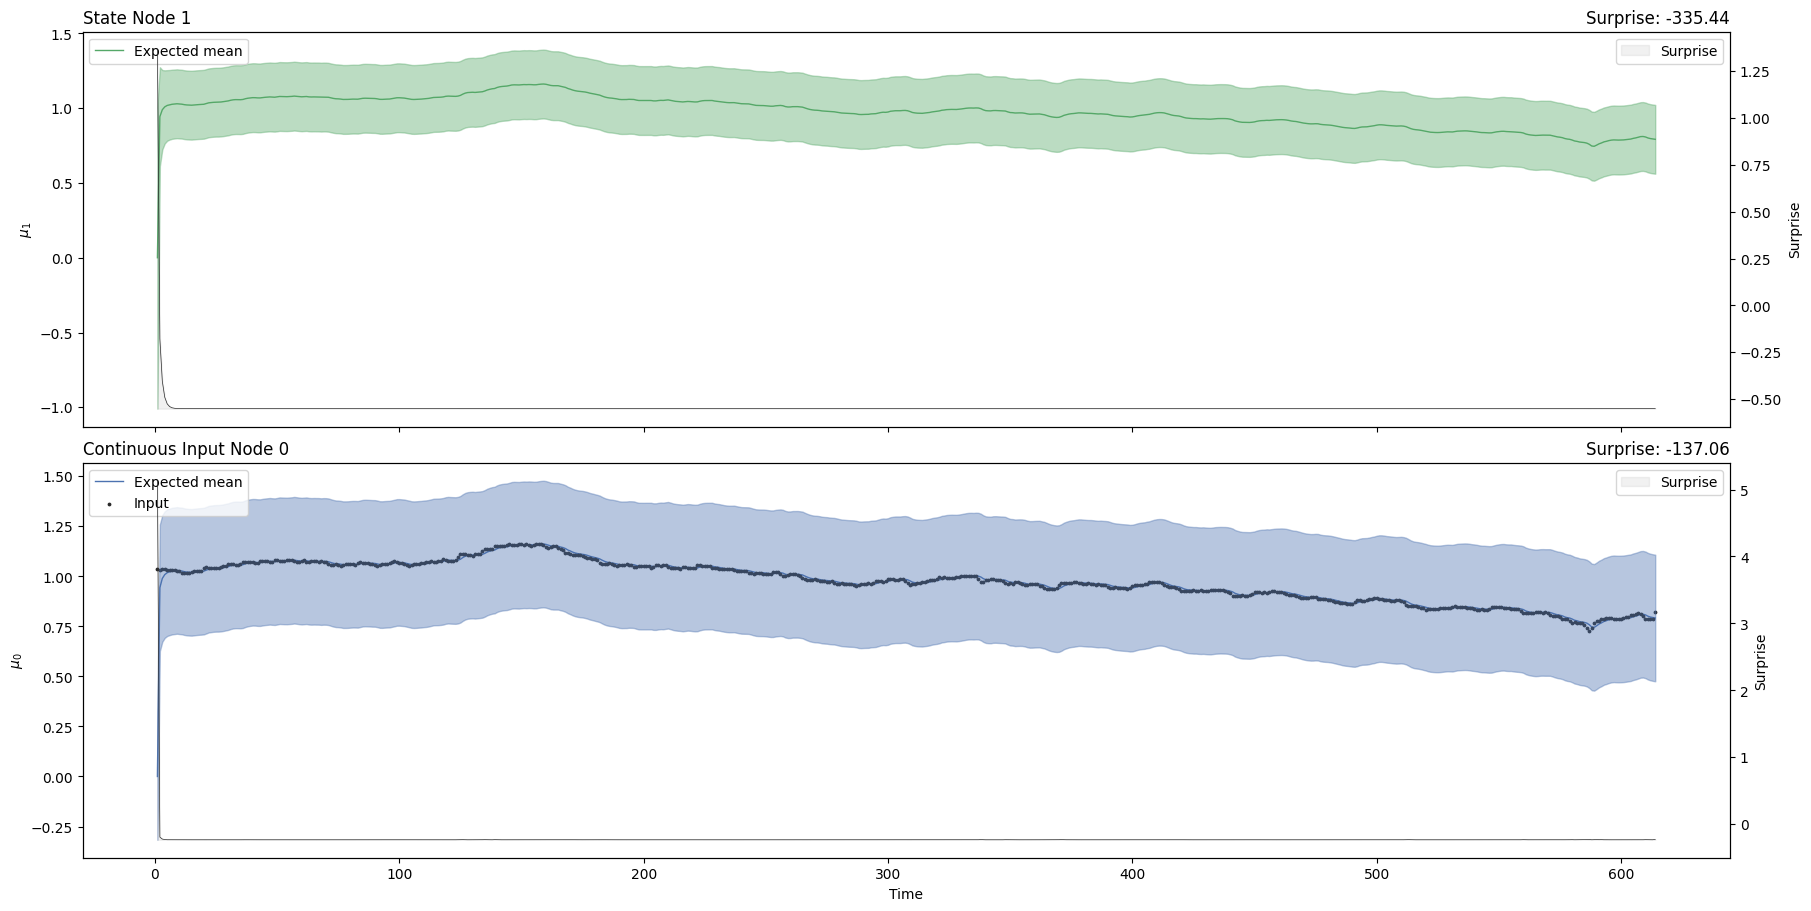

In [5]:
timeseries = load_data("continuous")
agent_1.input_data(input_data=timeseries)
agent_1.plot_trajectories()

#### Predict Future Trajectories
We generate 10 steps of predictions from the current state using forward inference.
This simulates It allows us to see how the model generalizes to future unseen states.


Using initial state: {-1: {'time_step': Array(1., dtype=float32)}, 0: {'autoconnection_strength': Array(0., dtype=float32, weak_type=True), 'expected_mean': Array(0.7918048, dtype=float32), 'expected_precision': Array(10., dtype=float32, weak_type=True), 'mean': Array(0.8241, dtype=float32), 'observed': Array(1, dtype=int32), 'precision': Array(10., dtype=float32, weak_type=True), 'temp': {'effective_precision': Array(0.9090909, dtype=float32), 'value_prediction_error': Array(0.03229523, dtype=float32), 'volatility_prediction_error': Array(0.01042986, dtype=float32)}, 'tonic_drift': Array(0., dtype=float32, weak_type=True), 'tonic_volatility': Array(0., dtype=float32, weak_type=True), 'value_coupling_children': None, 'value_coupling_parents': (Array(1., dtype=float32, weak_type=True),), 'volatility_coupling_children': None, 'volatility_coupling_parents': None}, 1: {'autoconnection_strength': Array(1., dtype=float32, weak_type=True), 'expected_mean': Array(0.7918048, dtype=float32), 'ex

array([<Axes: title={'left': 'State Node 1'}, ylabel='$\\mu_{1}$'>,
       <Axes: title={'left': 'Continuous Input Node 0'}, xlabel='Time', ylabel='$\\mu_{0}$'>],
      dtype=object)

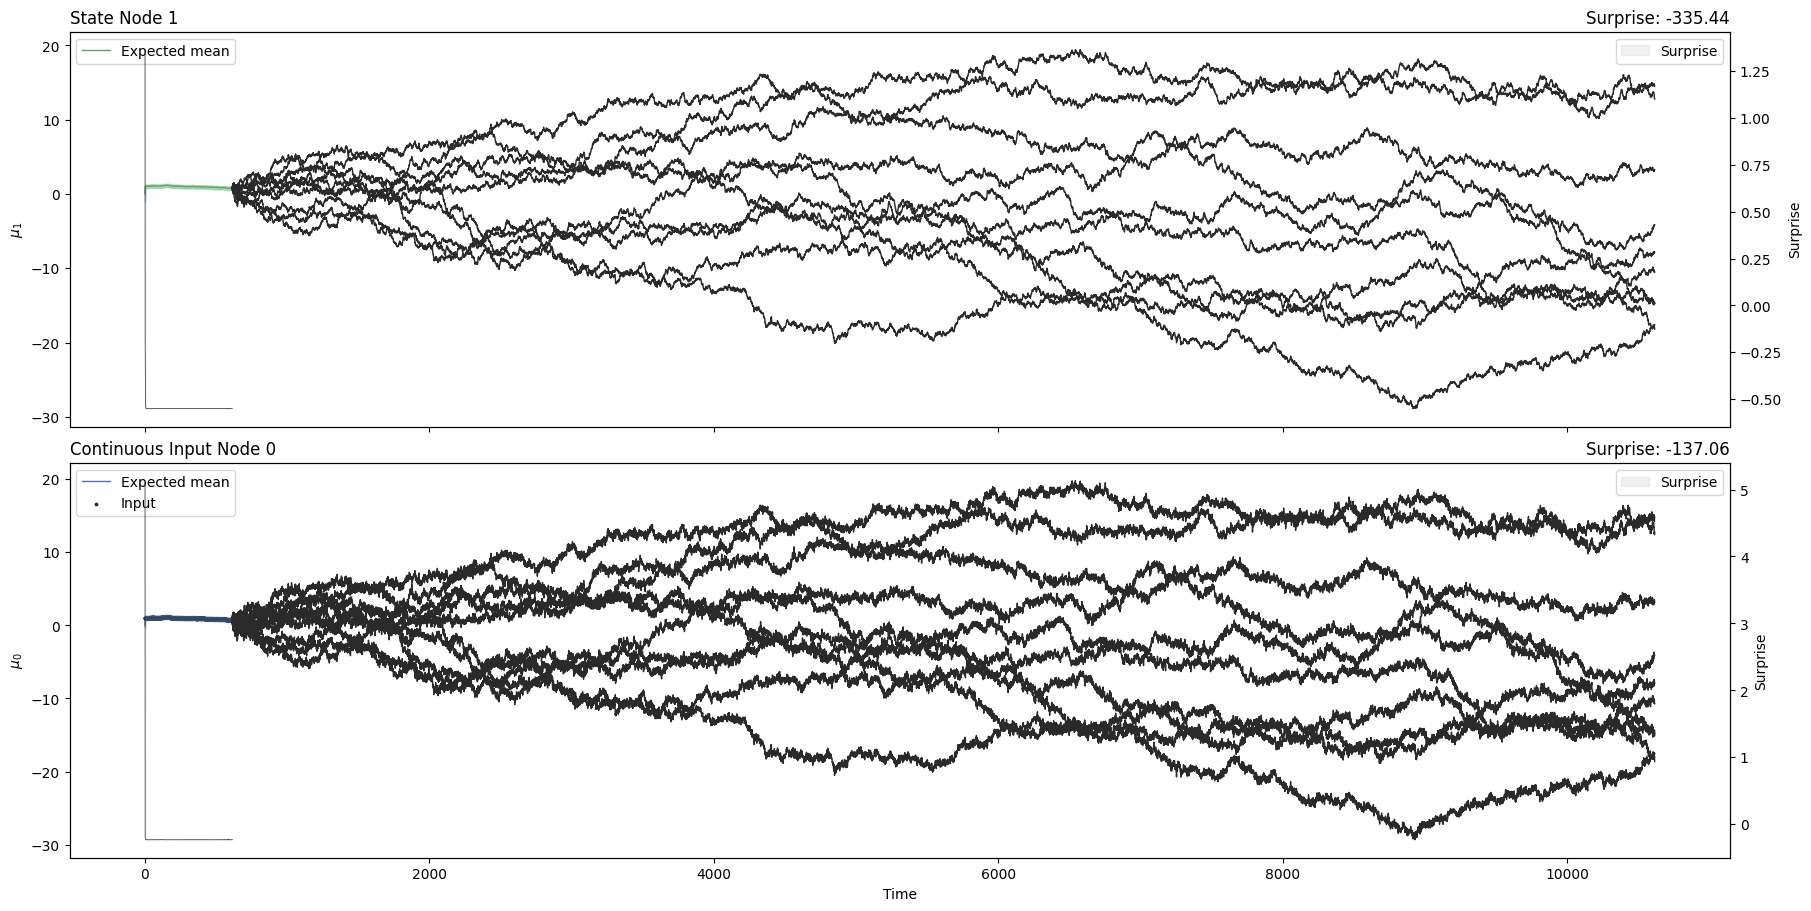

In [6]:
agent_1.predicts(n_predictions=10,time_steps=np.ones(10000))
agent_1.plot_trajectories_sim()

#### Define an Agent with a Binary Node
This agent uses a discrete binary node x_0 \in \{0, 1\}, with high precision (strong belief).
The generative model is now:


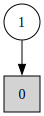

In [11]:
# Define an agent with a binary node and display the network
agent_2 = (
    Network()  # Create a new network
    .add_nodes(kind="binary-state", precision=1e2)  # Add Node 1: Binary state node with a specified precision
    .add_nodes(value_children=[0])  # Add Node 2: Child node linked to Node 1
)

# Plot the network structure
agent_2.plot_network()

#### Sample from the Binary Node

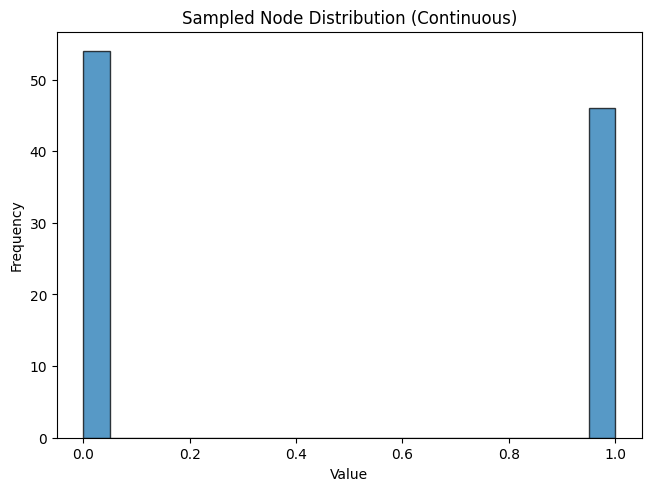

In [12]:
# Set the number of samples
num_samples = 100  # Number of times to sample
rng_key = random.PRNGKey(0)  # Base random number generator key

# Initialize a list to collect all samples
all_samples = []

# Loop to generate samples
for i in range(num_samples):
    subkey = random.fold_in(rng_key, i)  # Get a new subkey for each iteration
    sample = sample_node_distribution(
        attributes=agent_2.attributes,
        node_idx=0,
        rng_key=subkey,
        edges=agent_2.edges,
    )
    all_samples.append(sample)  # Append the sample to the list


# Plot the accumulated samples
plt.hist(all_samples, bins=20, alpha=0.75, edgecolor='k')
plt.title("Sampled Node Distribution (Continuous)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

#### Input Binary Data and Predict Future States
We feed binary observations to the network and observe the inference dynamics.

array([<Axes: title={'left': 'State Node 1'}, ylabel='$\\mu_{1}$'>,
       <Axes: title={'left': 'Binary Input Node 0'}, xlabel='Time', ylabel='$\\mu_{0}$'>],
      dtype=object)

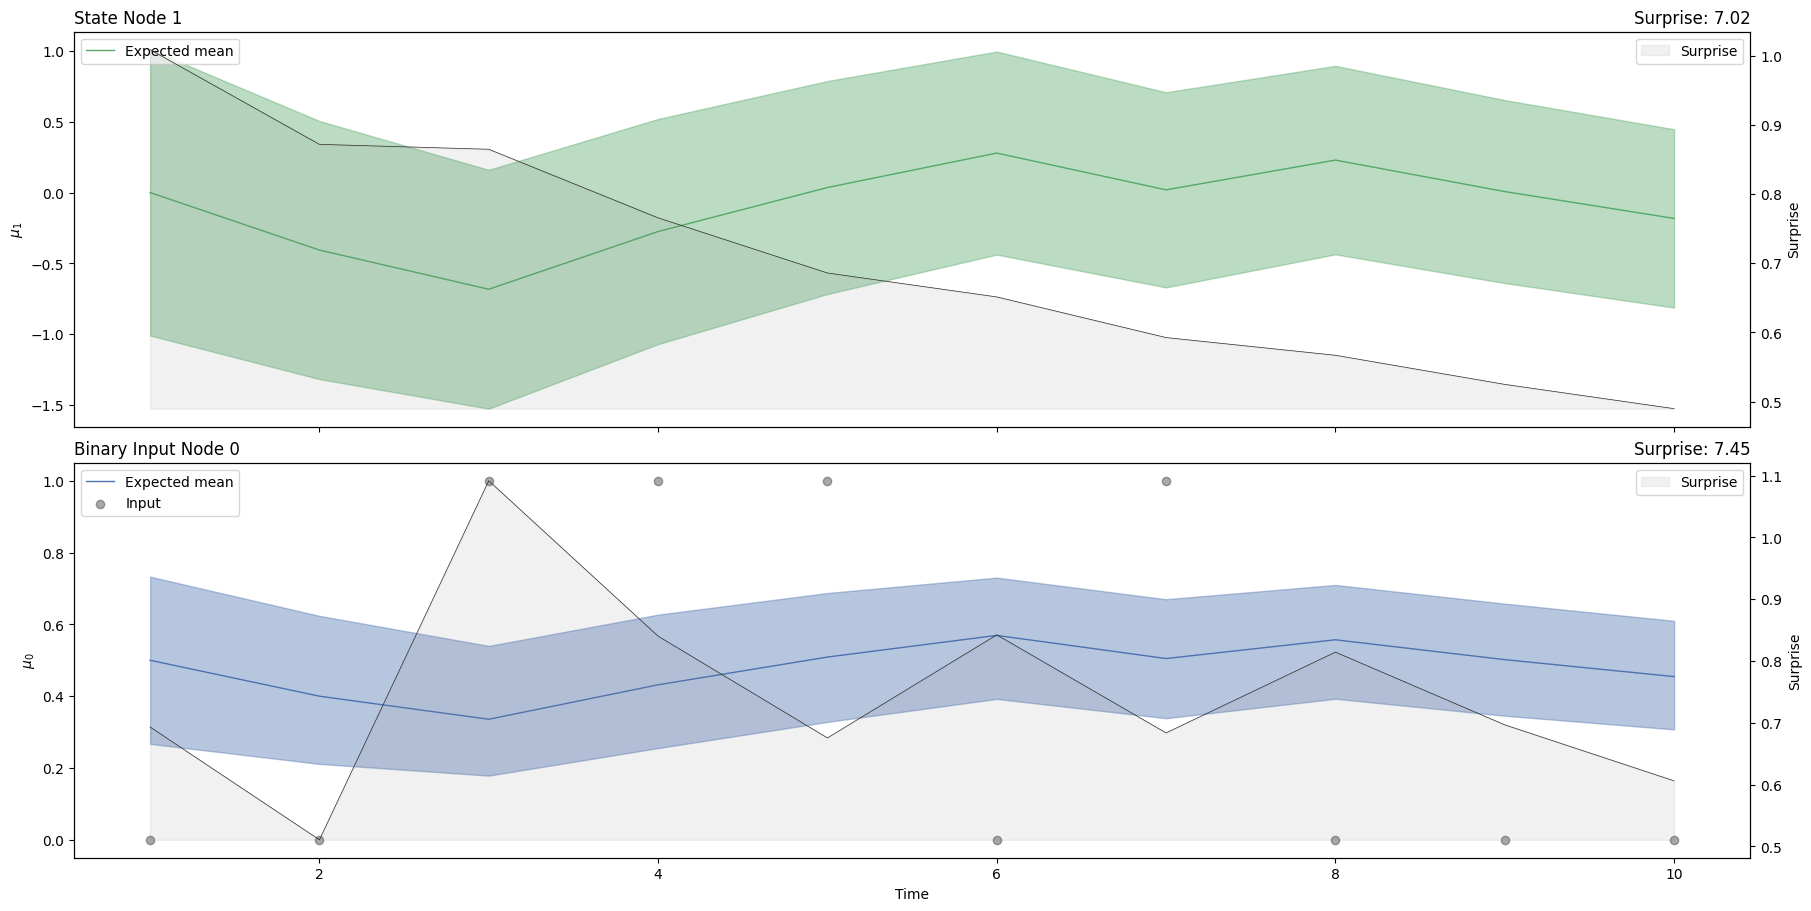

In [24]:
# input_data
agent_2.input_data(np.random.choice([0., 1.], size=10))  # Feed data to the network

# Plot the network structure 
agent_2.plot_trajectories()

In [25]:
agent_2.predicts(n_predictions=10,time_steps=np.ones(10))
agent_2.plot_trajectories_sim()

Using initial state: {-1: {'time_step': Array(1., dtype=float32)}, 0: {'expected_mean': Array(0.4544857, dtype=float32), 'expected_precision': Array(0.24792846, dtype=float32), 'mean': Array(0., dtype=float32), 'observed': Array(1, dtype=int32), 'precision': Array(0.24792846, dtype=float32), 'temp': {'value_prediction_error': Array(-1.8331325, dtype=float32)}, 'value_coupling_parents': (Array(1., dtype=float32, weak_type=True),)}, 1: {'autoconnection_strength': Array(1., dtype=float32, weak_type=True), 'expected_mean': Array(-0.18256244, dtype=float32), 'expected_precision': Array(2.5244827, dtype=float32), 'mean': Array(-0.34649402, dtype=float32), 'observed': Array(1, dtype=int32, weak_type=True), 'precision': Array(2.772411, dtype=float32), 'temp': {'effective_precision': Array(0.04623751, dtype=float32), 'value_prediction_error': Array(0., dtype=float32, weak_type=True), 'volatility_prediction_error': Array(0., dtype=float32, weak_type=True)}, 'tonic_drift': Array(0., dtype=float32

## Approaching active inference
```{warning}
Work in progress
```

# System configuration

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib